##Differentiating Artificial vs. Natural Objects With Neural Networks##
<br>
The objective of this project is to attempt to locate artificial objects underwater using sonar. The dataset can be found at https://www.openml.org/d/40, and describes two types of object: an artificial cylinder and a "roughly cylindrical" rock. For the purposes of the initial dataset, the artificial cylinder represented a mine, but for this project it will represent an artificial object we are trying to retrieve, such as an underwater buoy. Instead of trying to avoid mines where false negatives would be disastrous, we are trying to avoid the opportunity cost of false positives: each failed attempt at retrieval represents the wasted time of a ship's crew. The objective is to make a tool that would augment the crew's existing ability to use sonar, rather than replace it entirely.

In [1]:
# basic imports
import pandas as pd
import numpy as np
import seaborn as sns
import tensorflow as tf

# building the NN
from tensorflow import keras
from keras.layers import Dense
from keras.models import Sequential, load_model

# testing the NN
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, confusion_matrix, ConfusionMatrixDisplay

# Quality of life
from IPython import display

In [2]:
!pip install datapackage
import datapackage

display.Javascript("google.colab.output.setIframeHeight('300px');")

<IPython.core.display.Javascript object>

In [3]:
data_url = 'https://datahub.io/machine-learning/sonar/datapackage.json'

package = datapackage.Package(data_url)

resources = package.resources
for resource in resources:
    if resource.tabular:
        data = pd.read_csv(resource.descriptor['path'])

In [4]:
data

,attribute_1,attribute_2,attribute_3,attribute_4,attribute_5,attribute_6,attribute_7,attribute_8,attribute_9,attribute_10,...,attribute_52,attribute_53,attribute_54,attribute_55,attribute_56,attribute_57,attribute_58,attribute_59,attribute_60,Class
0,0.0200,0.0371,0.0428,0.0207,0.0954,0.0986,0.1539,0.1601,0.3109,0.2111,...,0.0027,0.0065,0.0159,0.0072,0.0167,0.0180,0.0084,0.0090,0.0032,Rock
1,0.0453,0.0523,0.0843,0.0689,0.1183,0.2583,0.2156,0.3481,0.3337,0.2872,...,0.0084,0.0089,0.0048,0.0094,0.0191,0.0140,0.0049,0.0052,0.0044,Rock
2,0.0262,0.0582,0.1099,0.1083,0.0974,0.2280,0.2431,0.3771,0.5598,0.6194,...,0.0232,0.0166,0.0095,0.0180,0.0244,0.0316,0.0164,0.0095,0.0078,Rock
3,0.0100,0.0171,0.0623,0.0205,0.0205,0.0368,0.1098,0.1276,0.0598,0.1264,...,0.0121,0.0036,0.0150,0.0085,0.0073,0.0050,0.0044,0.0040,0.0117,Rock
4,0.0762,0.0666,0.0481,0.0394,0.0590,0.0649,0.1209,0.2467,0.3564,0.4459,...,0.0031,0.0054,0.0105,0.0110,0.0015,0.0072,0.0048,0.0107,0.0094,Rock
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
203,0.0187,0.0346,0.0168,0.0177,0.0393,0.1630,0.2028,0.1694,0.2328,0.2684,...,0.0116,0.0098,0.0199,0.0033,0.0101,0.0065,0.0115,0.0193,0.0157,Mine
204,0.0323,0.0101,0.0298,0.0564,0.0760,0.0958,0.0990,0.1018,0.1030,0.2154,...,0.0061,0.0093,0.0135,0.0063,0.0063,0.0034,0.0032,0.0062,0.0067,Mine
205,0.0522,0.0437,0.0180,0.0292,0.0351,0.1171,0.1257,0.1178,0.1258,0.2529,...,0.0160,0.0029,0.0051,0.0062,0.0089,0.0140,0.0138,0.0077,0.0031,Mine
206,0.0303,0.0353,0.0490,0.0608,0.0167,0.1354,0.1465,0.1123,0.1945,0.2354,...,0.0086,0.0046,0.0126,0.0036,0.0035,0.0034,0.0079,0.0036,0.0048,Mine


In [5]:
# find if there are values below zero
(data.loc[:, data.columns != "Class"] < 0).sum().sum()

0

In [6]:
# find if there are values that are zero
(data.loc[:, data.columns != "Class"] == 0).sum().sum()

9

In [7]:
# Data has already been cleaned and normalized, so these steps will not be necessary.
X, y = data[data.columns.drop('Class')], data['Class']

X.to_numpy()
y.to_numpy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=777)

In [8]:
# convert "rock"/"mine" to 0/1
Encoder = tf.keras.layers.Hashing(
    2,
    mask_value=None,
    salt=None,
    output_mode='int',
    sparse=False,
)

In [9]:
y_train = Encoder(y_train)
y_test = Encoder(y_test)

In [22]:
# simple relu-based model as the "test case"
model_1 = keras.models.Sequential([
    tf.keras.layers.InputLayer(60),
    tf.keras.layers.Dense(120, activation="relu"),
    tf.keras.layers.Dense(240, activation="relu"),
    tf.keras.layers.Dense(120, activation="relu"),
    tf.keras.layers.Dense(1, activation="sigmoid")
])

model_1.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01), loss='BinaryCrossentropy', metrics=['BinaryAccuracy'])

In [23]:
History_1 = model_1.fit(X_train, y_train, epochs=125, batch_size=30)
display.Javascript("google.colab.output.setIframeHeight('300px');")

Epoch 1/125
6/6 [==============================] - 1s 3ms/step - loss: 0.7009 - binary_accuracy: 0.5060
Epoch 2/125
6/6 [==============================] - 0s 2ms/step - loss: 0.5671 - binary_accuracy: 0.7229
Epoch 3/125
6/6 [==============================] - 0s 2ms/step - loss: 0.5146 - binary_accuracy: 0.7169
Epoch 4/125
6/6 [==============================] - 0s 2ms/step - loss: 0.5032 - binary_accuracy: 0.7108
Epoch 5/125
6/6 [==============================] - 0s 3ms/step - loss: 0.4174 - binary_accuracy: 0.8193
Epoch 6/125
6/6 [==============================] - 0s 3ms/step - loss: 0.3632 - binary_accuracy: 0.8313
Epoch 7/125
6/6 [==============================] - 0s 3ms/step - loss: 0.4187 - binary_accuracy: 0.7952
Epoch 8/125
6/6 [==============================] - 0s 3ms/step - loss: 0.3446 - binary_accuracy: 0.8494
Epoch 9/125
6/6 [==============================] - 0s 3ms/step - loss: 0.2810 - binary_accuracy: 0.8855
Epoch 10/125
6/6 [==============================] - 0s 3ms/step 

<IPython.core.display.Javascript object>

In [24]:
model_1.evaluate(X_test, y_test)

2/2 [==============================] - 0s 7ms/step - loss: 1.8410 - binary_accuracy: 0.7857


[1.8409982919692993, 0.7857142686843872]

In [25]:
# altering the activation functions
model_2 = keras.models.Sequential([
    tf.keras.layers.InputLayer(60),
    tf.keras.layers.Dense(120, activation="relu"), # changing this results in overfitting
    tf.keras.layers.Dense(240, activation="gelu"), # gelu and selu
    tf.keras.layers.Dense(120, activation="gelu"),
    tf.keras.layers.Dense(1, activation="sigmoid")
])

model_2.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01), loss='BinaryCrossentropy', metrics=['BinaryAccuracy'])

In [26]:
History_2 = model_2.fit(X_train, y_train, epochs=125, batch_size=30)
display.Javascript("google.colab.output.setIframeHeight('300px');")

Epoch 1/125
6/6 [==============================] - 1s 2ms/step - loss: 0.9108 - binary_accuracy: 0.5783
Epoch 2/125
6/6 [==============================] - 0s 2ms/step - loss: 0.6142 - binary_accuracy: 0.6928
Epoch 3/125
6/6 [==============================] - 0s 3ms/step - loss: 0.5573 - binary_accuracy: 0.6988
Epoch 4/125
6/6 [==============================] - 0s 2ms/step - loss: 0.5205 - binary_accuracy: 0.7349
Epoch 5/125
6/6 [==============================] - 0s 3ms/step - loss: 0.4610 - binary_accuracy: 0.7530
Epoch 6/125
6/6 [==============================] - 0s 3ms/step - loss: 0.4208 - binary_accuracy: 0.8012
Epoch 7/125
6/6 [==============================] - 0s 3ms/step - loss: 0.4212 - binary_accuracy: 0.7892
Epoch 8/125
6/6 [==============================] - 0s 3ms/step - loss: 0.3874 - binary_accuracy: 0.7831
Epoch 9/125
6/6 [==============================] - 0s 3ms/step - loss: 0.3449 - binary_accuracy: 0.8193
Epoch 10/125
6/6 [==============================] - 0s 3ms/step 

<IPython.core.display.Javascript object>

In [27]:
model_2.evaluate(X_test, y_test)

2/2 [==============================] - 0s 6ms/step - loss: 1.5470 - binary_accuracy: 0.8333


[1.546960711479187, 0.8333333134651184]

In [28]:
model_3 = keras.models.Sequential([
    tf.keras.layers.InputLayer(60),
    tf.keras.layers.Dense(45, activation="relu"),
    tf.keras.layers.Dense(45, activation="gelu"),
    tf.keras.layers.Dense(45, activation="gelu"),
    tf.keras.layers.Dense(45, activation="selu"),
    tf.keras.layers.Dense(45, activation="gelu"),
    tf.keras.layers.Dense(45, activation="gelu"),
    tf.keras.layers.Dense(45, activation="selu"),
    tf.keras.layers.Dense(1, activation="sigmoid")
])

model_3.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01), loss='BinaryCrossentropy', metrics=['BinaryAccuracy'])

In [29]:
History_3 = model_3.fit(X_train, y_train, epochs=125, batch_size=30)
display.Javascript("google.colab.output.setIframeHeight('300px');")

Epoch 1/125
6/6 [==============================] - 1s 4ms/step - loss: 0.7221 - binary_accuracy: 0.5482
Epoch 2/125
6/6 [==============================] - 0s 2ms/step - loss: 0.6879 - binary_accuracy: 0.5241
Epoch 3/125
6/6 [==============================] - 0s 3ms/step - loss: 0.6345 - binary_accuracy: 0.6687
Epoch 4/125
6/6 [==============================] - 0s 3ms/step - loss: 0.5945 - binary_accuracy: 0.6687
Epoch 5/125
6/6 [==============================] - 0s 2ms/step - loss: 0.5045 - binary_accuracy: 0.7530
Epoch 6/125
6/6 [==============================] - 0s 2ms/step - loss: 0.4352 - binary_accuracy: 0.7771
Epoch 7/125
6/6 [==============================] - 0s 3ms/step - loss: 0.4150 - binary_accuracy: 0.8253
Epoch 8/125
6/6 [==============================] - 0s 3ms/step - loss: 0.3895 - binary_accuracy: 0.8313
Epoch 9/125
6/6 [==============================] - 0s 3ms/step - loss: 0.3608 - binary_accuracy: 0.8253
Epoch 10/125
6/6 [==============================] - 0s 3ms/step 

<IPython.core.display.Javascript object>

In [30]:
model_3.evaluate(X_test, y_test)

2/2 [==============================] - 0s 6ms/step - loss: 1.3617 - binary_accuracy: 0.8095


[1.3617035150527954, 0.8095238208770752]

In [31]:
model_4 = keras.models.Sequential([
    tf.keras.layers.InputLayer(60),
    tf.keras.layers.Dense(360, activation="relu"),
    tf.keras.layers.Dense(240, activation="gelu"),
    tf.keras.layers.Dense(1, activation="sigmoid")
])

model_4.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01), loss='BinaryCrossentropy', metrics=['BinaryAccuracy'])

In [32]:
History_4 = model_4.fit(X_train, y_train, epochs=125, batch_size=30)
display.Javascript("google.colab.output.setIframeHeight('300px');")

Epoch 1/125
6/6 [==============================] - 1s 3ms/step - loss: 0.6255 - binary_accuracy: 0.6205
Epoch 2/125
6/6 [==============================] - 0s 3ms/step - loss: 0.5302 - binary_accuracy: 0.7048
Epoch 3/125
6/6 [==============================] - 0s 3ms/step - loss: 0.4361 - binary_accuracy: 0.7952
Epoch 4/125
6/6 [==============================] - 0s 3ms/step - loss: 0.3870 - binary_accuracy: 0.8373
Epoch 5/125
6/6 [==============================] - 0s 3ms/step - loss: 0.3668 - binary_accuracy: 0.8253
Epoch 6/125
6/6 [==============================] - 0s 3ms/step - loss: 0.3353 - binary_accuracy: 0.8916
Epoch 7/125
6/6 [==============================] - 0s 3ms/step - loss: 0.3535 - binary_accuracy: 0.8012
Epoch 8/125
6/6 [==============================] - 0s 3ms/step - loss: 0.4233 - binary_accuracy: 0.7711
Epoch 9/125
6/6 [==============================] - 0s 3ms/step - loss: 0.4776 - binary_accuracy: 0.7711
Epoch 10/125
6/6 [==============================] - 0s 4ms/step 

<IPython.core.display.Javascript object>

In [33]:
model_4.evaluate(X_test, y_test)

2/2 [==============================] - 0s 5ms/step - loss: 1.1881 - binary_accuracy: 0.8571


[1.1881202459335327, 0.8571428656578064]

In [34]:
model_1_pred = model_1.predict(X_test)
y_pred_1 = [int(round(x[0])) for x in model_1_pred]

model_2_pred = model_2.predict(X_test)
y_pred_2 = [int(round(x[0])) for x in model_2_pred]

model_3_pred = model_3.predict(X_test)
y_pred_3 = [int(round(x[0])) for x in model_3_pred]

model_4_pred = model_4.predict(X_test)
y_pred_4 = [int(round(x[0])) for x in model_4_pred]

2/2 [==============================] - 0s 3ms/step


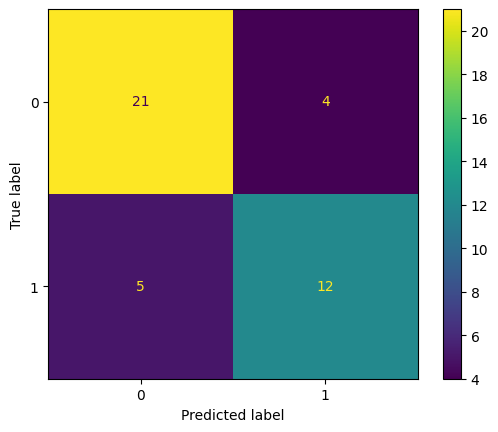

In [35]:
confusionMatrix_1 = confusion_matrix(y_true=y_test, y_pred=y_pred_1)
displayConfusionMatrix = ConfusionMatrixDisplay(confusionMatrix_1)
displayConfusionMatrix.plot()

# approximately 10% of the time, the first (relu-only) model will produce a false negative, wasting crucial time. More importantly, 25% of all positives are false, making the model difficult to trust.

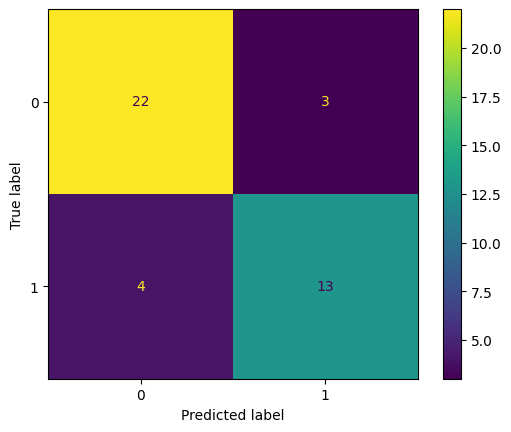

In [36]:
confusionMatrix_2 = confusion_matrix(y_true=y_test, y_pred=y_pred_2)
displayConfusionMatrix = ConfusionMatrixDisplay(confusionMatrix_2)
displayConfusionMatrix.plot()

# Model 2 improves on model 1 somewhat in all regards, with our important false-negative number reducing to only 7% of the time in total, although it is 19% of all positive cases.

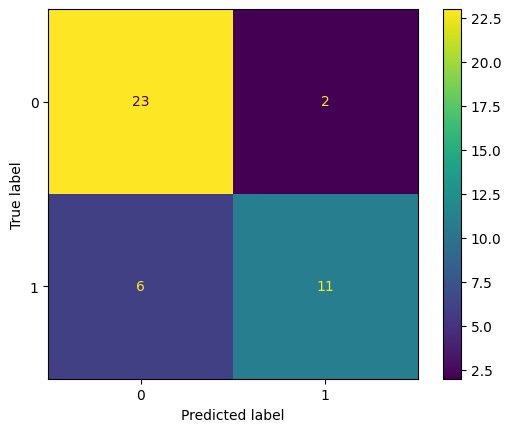

In [37]:
confusionMatrix_3 = confusion_matrix(y_true=y_test, y_pred=y_pred_3)
displayConfusionMatrix = ConfusionMatrixDisplay(confusionMatrix_3)
displayConfusionMatrix.plot()

# model 3, our "narrow model" produces surprisingly good results. Its false negatives are higher than model 2 and overall it is less accurate, but it is wrong only 15% of the time when it comes up positive, rather than 19% of the the time.

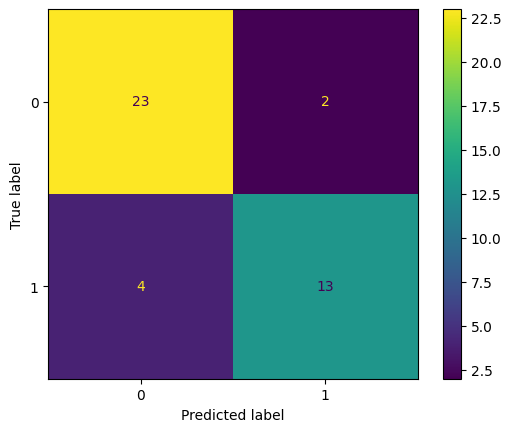

In [38]:
confusionMatrix_4 = confusion_matrix(y_true=y_test, y_pred=y_pred_4)
displayConfusionMatrix = ConfusionMatrixDisplay(confusionMatrix_4)
displayConfusionMatrix.plot()

# Model 4, the wide model, is the best in all regards. It is wrong when it comes up positive only 13% of the time, almost half of the number for model 1.